# Real/Fake Job Postings Prediction

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Assignment Description:</b> 

- Dataset: The dataset used in this project was downloaded from Kaggle.com. It was provided by the university of the Aegean and contains 18,000 job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.- : Our goal is to build four models for job postings classification and select the model with the highest accuracy, precision, _ scores.  </div>

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px"> <b>Approach:</b><br>
Random forest, support vector machines, multinomial naive bayes, and neural networks work best for text classification. We built these four models, evaluated them using accuracy, precision, recall, f1 score tests. We also built ROC curves and confusion matrices. Random forest is the best model. Please, find the evaluation results below.   е</div><br>

## Exploratory Data Analysis 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
from wordcloud import WordCloud
from collections import Counter
import timeit
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RandomizedSearchCV, StratifiedKFold, RepeatedKFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score

import tensorflow as tf
import keras_tuner as kt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

We uploaded the libraries and now we'll upload and read the data

In [2]:
postings = pd.read_csv(r'C:\Users\vetal\Desktop\Elena\DS books\MSDS 422\Online Retail\fake_job_postings.csv')
postings.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


We can see that the dataset contains mostly categorical data.

In [3]:
postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

We have 18 columns and 17880 entries. Now let's check for NaN values:

In [4]:
postings.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

Most columns contain NaN values. We delete the columns that contain more than 5000 NaN values (more than 30% of total values in the column). We replace NaN values with "unknown" in the remaining columns.

In [5]:
columns_dropped = ['salary_range', 'department', 'benefits', 'required_experience', 'function', 'required_education']
postings_new = postings.drop(columns_dropped, axis=1)
postings_new.head()

,job_id,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,industry,fraudulent
0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Other,NaN,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Full-time,Marketing and Advertising,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Full-time,Computer Software,0
4,5,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,Full-time,Hospital & Health Care,0


In [6]:
postings_new['description'].fillna("unknown", inplace=True)

We remove duplicates:

In [7]:
postings_new = postings_new.drop_duplicates()

Let's count the number of values for some columns and display five most popular values for each feature.

In [8]:
columns = ['title', 'location', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'industry', 'fraudulent']
for e in columns:
    print(e, postings_new[columns][e].value_counts().head())

title title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
Name: count, dtype: int64
location location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
Name: count, dtype: int64
telecommuting telecommuting
0    17113
1      767
Name: count, dtype: int64
has_company_logo has_company_logo
1    14220
0     3660
Name: count, dtype: int64
has_questions has_questions
0    9088
1    8792
Name: count, dtype: int64
employment_type employment_type
Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64
industry industry
Information Technology and Services    1734
Computer Software                   

We will build bar charts to see how popular different employment types and industries.

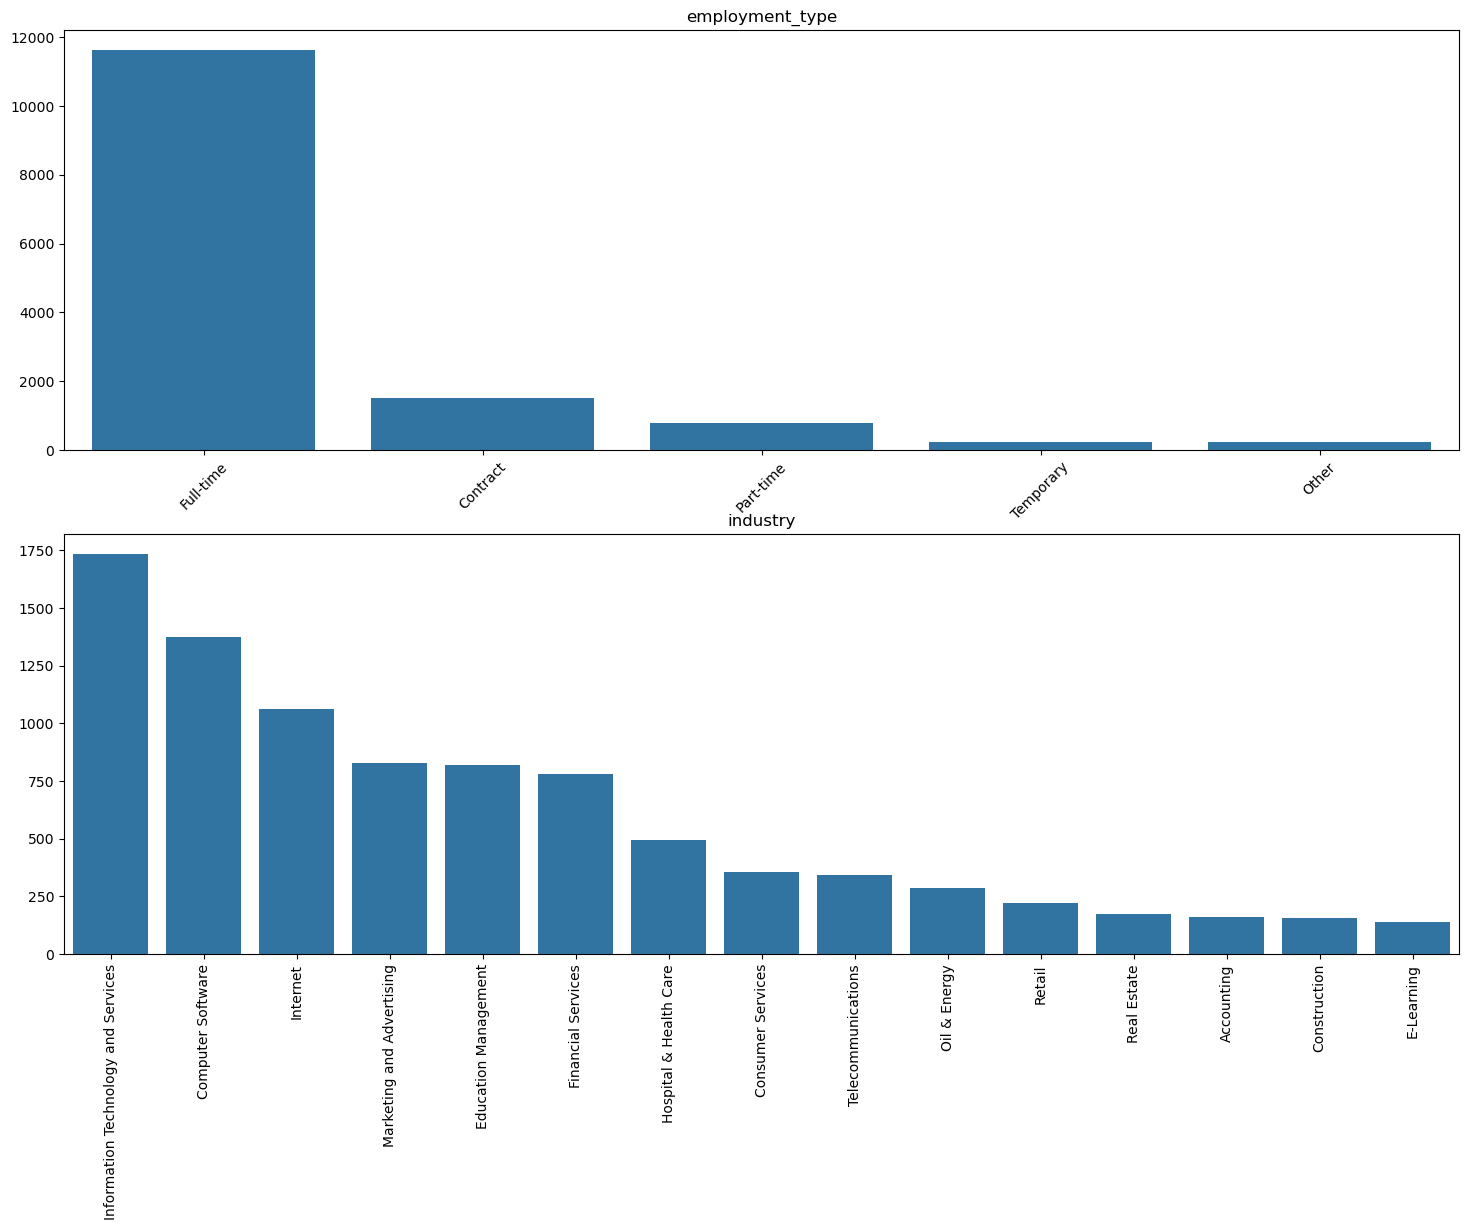

In [9]:
visualize = ['employment_type', 'industry']
fig, ax =plt.subplots(2,1, figsize=(18, 12))
j=0
for col in visualize:
    ax_g =ax[j]
    chart = sns.countplot(postings_new, x=col, ax=ax_g, order=postings_new[col].value_counts().iloc[:15].index)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90 if j == 1 else 45)
    ax_g.set_ylabel(None)
    ax_g.set_xlabel(None)
    ax_g.set_title(col, fontsize=12)
    j+=1
fig.show()

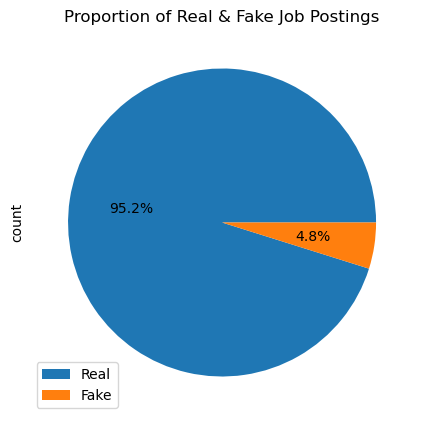

In [10]:
postings_new['fraudulent'].value_counts().plot.pie(figsize=(5,5),title="Proportion of Real & Fake Job Postings",labels=['',''],autopct='%1.1f%%')
labels=["Real", "Fake"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

The most valuable data we have is in the form of text. We suppose that description and requirements are the most useful columns. Let's remove stop words, numbers, punctuation marks. Then we'll build word clouds for "description" and "requirements" columns to see top words in real and fake job postings. 

## Feature Engineering

In [11]:
def clean(text):
   # wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    stop_words = nltk.corpus.stopwords.words('english')
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
  #  text = [wn.lemmatize(word) for word in text]
    text = [word for word in text.split() if word not in stop_words]
    return ' '.join(text)

In [12]:
postings_new['requirements'][0]

'Experience with content management systems a major plus (any blogging counts!)Familiar with the Food52 editorial voice and aestheticLoves food, appreciates the importance of home cooking and cooking with the seasonsMeticulous editor, perfectionist, obsessive attention to detail, maddened by typos and broken links, delighted by finding and fixing themCheerful under pressureExcellent communication skillsA+ multi-tasker and juggler of responsibilities big and smallInterested in and engaged with social media like Twitter, Facebook, and PinterestLoves problem-solving and collaborating to drive Food52 forwardThinks big picture but pitches in on the nitty gritty of running a small company (dishes, shopping, administrative support)Comfortable with the realities of working for a startup: being on call on evenings and weekends, and working long hours'

In [13]:
postings_new['requirements']=postings_new['requirements'].astype(str)
postings_new['requirements']=postings_new['requirements'].apply(clean)

In [14]:
postings_new['requirements'][0]

'experience content management systems major plus blogging counts familiar food editorial voice aestheticloves food appreciates importance home cooking cooking seasonsmeticulous editor perfectionist obsessive attention detail maddened typos broken links delighted finding fixing themcheerful pressureexcellent communication skillsa multi tasker juggler responsibilities big smallinterested engaged social media like twitter facebook pinterestloves problem solving collaborating drive food forwardthinks big picture pitches nitty gritty running small company dishes shopping administrative support comfortable realities working startup call evenings weekends working long hours'

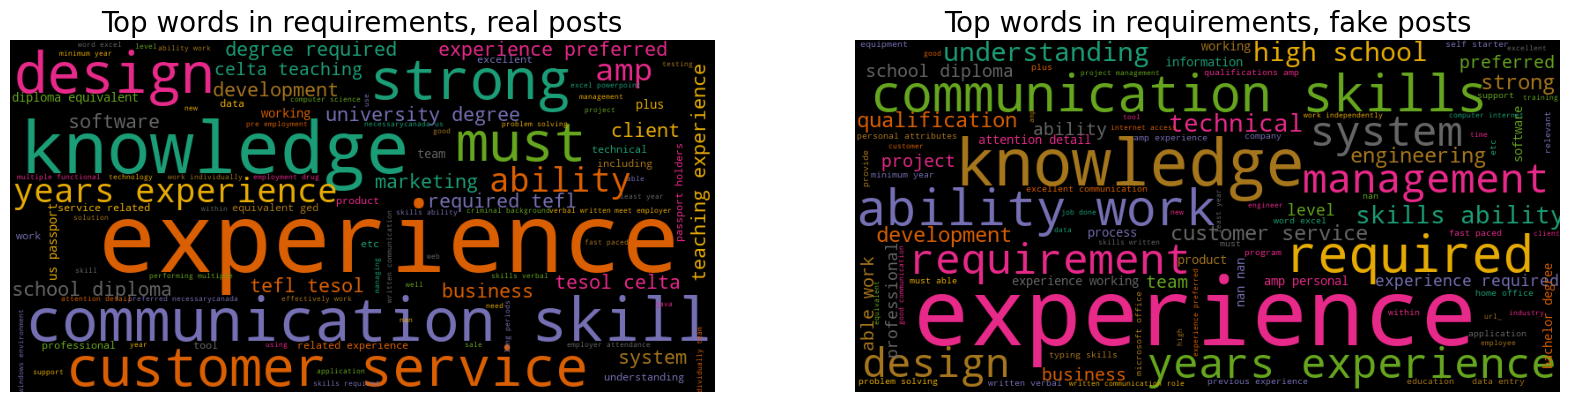

In [15]:
n_posts = 1000
q_S = ' '.join(postings_new[postings_new['fraudulent'] == 0]['requirements'].str.lower().values[:n_posts])
q_I = ' '.join(postings_new[postings_new['fraudulent'] == 1]['requirements'].str.lower().values[:n_posts])

wordcloud_S = WordCloud(max_font_size=None,scale = 2,colormap = 'Dark2').generate(q_S)
wordcloud_I = WordCloud(max_font_size=None,scale = 2,colormap = 'Dark2').generate(q_I)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(wordcloud_S)
ax[0].set_title('Top words in requirements, real posts',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_I)
ax[1].set_title('Top words in requirements, fake posts',fontsize = 20)
ax[1].axis("off")

plt.show()

In [16]:
postings_new['description']=postings_new['description'].astype(str)
postings_new['description']=postings_new['description'].apply(clean)

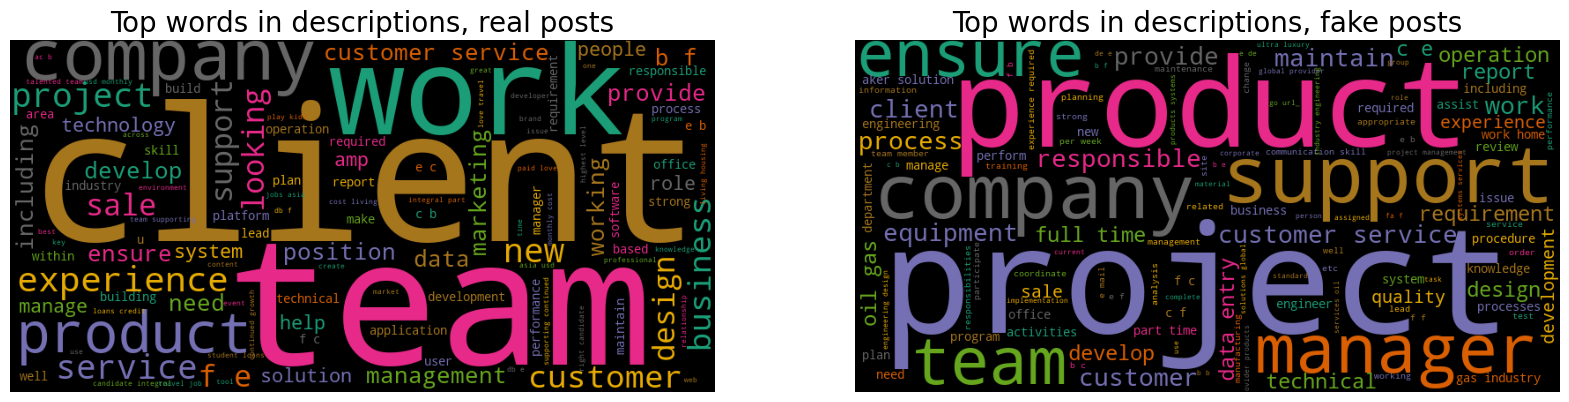

In [17]:
n_posts = 1000
q_S = ' '.join(postings_new[postings_new['fraudulent'] == 0]['description'].str.lower().values[:n_posts])
q_I = ' '.join(postings_new[postings_new['fraudulent'] == 1]['description'].str.lower().values[:n_posts])

wordcloud_S = WordCloud(max_font_size=None,scale = 2,colormap = 'Dark2').generate(q_S)
wordcloud_I = WordCloud(max_font_size=None,scale = 2,colormap = 'Dark2').generate(q_I)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(wordcloud_S)
ax[0].set_title('Top words in descriptions, real posts',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_I)
ax[1].set_title('Top words in descriptions, fake posts',fontsize = 20)
ax[1].axis("off")

plt.show()

The description column has different top words in real and fake job postings. We will tokenize and lemmatize this column.

In [18]:
lemmatizer = WordNetLemmatizer() ## создаём объект для 
tag_dict = {"a": wordnet.ADJ,
            "n": wordnet.NOUN,
            "v": wordnet.VERB,
            "r": wordnet.ADV}

def tokenize_lemmatize(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
   # print(tagged_tokens)
    lemmatize_tokens = [lemmatizer.lemmatize(word, tag_dict.get(tag[0].lower(), wordnet.NOUN)) for word, tag in tagged_tokens]
   # print(lemmatize_tokens)
    return ' '.join(lemmatize_tokens)

In [19]:
postings_new['description'][0]

'food fast growing james beard award winning online food community crowd sourced curated recipe hub currently interviewing full part time unpaid interns work small team editors executives developers new york city headquarters reproducing repackaging existing food content number partner sites huffington post yahoo buzzfeed various content management systemsresearching blogs websites provisions food affiliate programassisting day day affiliate program support screening affiliates assisting affiliate inquiriessupporting pr amp events neededhelping office administrative work filing mailing preparing meetingsworking developers document bugs suggest improvements sitesupporting marketing executive staff'

In [20]:
postings_new['clean_token']=postings_new['description'].apply(tokenize_lemmatize)
postings_new['clean_token'][0]

'food fast grow james beard award win online food community crowd source curated recipe hub currently interview full part time unpaid intern work small team editor executive developer new york city headquarters reproduce repackaging exist food content number partner sit huffington post yahoo buzzfeed various content management systemsresearching blog website provision food affiliate programassisting day day affiliate program support screen affiliate assist affiliate inquiriessupporting pr amp event neededhelping office administrative work filing mail prepare meetingsworking developer document bug suggest improvement sitesupporting marketing executive staff'

In [21]:
postings_new['clean_token'][0]

'food fast grow james beard award win online food community crowd source curated recipe hub currently interview full part time unpaid intern work small team editor executive developer new york city headquarters reproduce repackaging exist food content number partner sit huffington post yahoo buzzfeed various content management systemsresearching blog website provision food affiliate programassisting day day affiliate program support screen affiliate assist affiliate inquiriessupporting pr amp event neededhelping office administrative work filing mail prepare meetingsworking developer document bug suggest improvement sitesupporting marketing executive staff'

In [22]:
X = postings_new.drop("fraudulent",axis=1)
y = postings_new["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.80, random_state=42)

print("Data distribution:\n- Train: {} Test: {}".format(len(y_train),len(y_test)))

Data distribution:
- Train: 3576 Test: 14304


In [23]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(postings_new['clean_token']).toarray()
y = postings_new['fraudulent']

In [24]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Models Selection

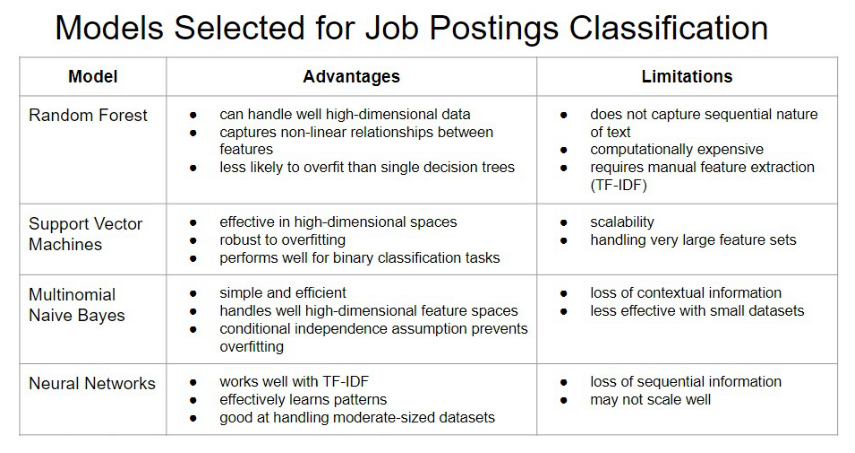

In [25]:
_=plt.figure(figsize=(12, 8), dpi=90)
plt.axis('off')
models = plt.imread('Models_selected.jpg')
plt.grid(False)
_=plt.imshow(models)

## Random Forest Classifier Model

In [26]:
rf = RandomForestClassifier(random_state=42)
scores = cross_val_score(rf,X_train,y_train.values.ravel(),cv=5)

In [27]:
print(scores)
scores.mean()

[0.97623209 0.97728067 0.97902831 0.9751835  0.97482517]


0.9765099493306414

In [28]:
# fit
rf.fit(X_train,y_train)

#use model to make predictions on train data
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

### Random Forest Model Evaluation on Train and Test Data

In [29]:
rf_train_accuracy = accuracy_score(y_train, y_rf_train_pred)
rf_train_precision = precision_score(y_train, y_rf_train_pred, average='weighted')
rf_train_recall = recall_score(y_train, y_rf_train_pred, average='weighted')
rf_train_f1score_test = f1_score(y_train, y_rf_train_pred, average='weighted')
print(f"accuracy train data: {rf_train_accuracy}")
print(f"precision train data: {rf_train_precision}")
print(f"recall train data: {rf_train_recall}")
print(f"F1 Score_test = {rf_train_f1score_test}")

accuracy train data: 0.9999300894854586
precision train data: 0.9999300946183892
recall train data: 0.9999300894854586
F1 Score_test = 0.9999300652353145


In [30]:
rf_test_accuracy = accuracy_score(y_test, y_rf_test_pred)
rf_test_precision = precision_score(y_test, y_rf_test_pred, average='weighted')
rf_test_recall = recall_score(y_test, y_rf_test_pred, average='weighted')
rf_test_f1score_test = f1_score(y_test, y_rf_test_pred, average='weighted')
print(f"accuracy test data: {rf_test_accuracy}")
print(f"precision test data: {rf_test_precision}")
print(f"recall test data: {rf_test_recall}")
print(f"F1 Score_test = {rf_test_f1score_test}")

accuracy test data: 0.9773489932885906
precision test data: 0.9776411405903407
recall test data: 0.9773489932885906
F1 Score_test = 0.9743177110218424


In [31]:
def ROC_curve (model, title, predict_func):
    #plot ROC curve
    y_pred_proba_train = predict_func(model, X_train) #model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
    auc_train = roc_auc_score(y_train, y_pred_proba_train)
    plt.figure(figsize=(5,3))
    plt.plot(fpr_train, tpr_train, label="Train AUC=" + str(auc_train))
    y_pred_proba_test = predict_func(model, X_test) #model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
    auc_test = roc_auc_score(y_test, y_pred_proba_test)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.plot(fpr_test, tpr_test, label="Test AUC=" + str(auc_test))
    plt.legend(loc=4)
    plt.grid(True) 
    plt.show()

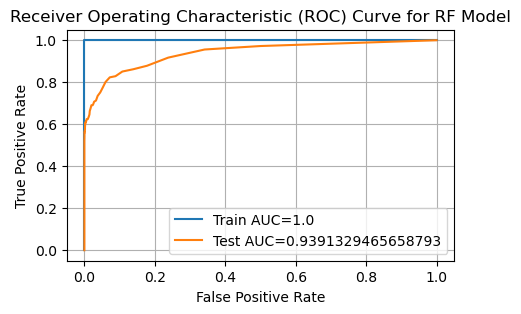

In [32]:
ROC_curve (rf, 'Receiver Operating Characteristic (ROC) Curve for RF Model', lambda x, y: x.predict_proba(y)[:, 1])

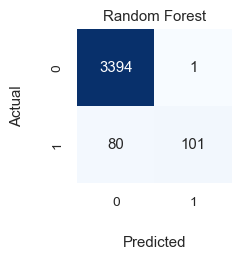

In [33]:
def confusion_matrix_map (y, y_pred, title):
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(2,2))
    sns.set(font_scale=0.9)
    ax = sns.heatmap(
    conf_matrix,  # confusion matrix 2D array 
    annot=True,              # show numbers in the cells
    fmt='d',                # show numbers as integers
    cbar=False,             # don't show the color bar
    cmap='Blues',           # customize color map
    vmax=conf_matrix.max() # to get better color contrast
    )

    ax.set_xlabel("Predicted", labelpad=20)
    ax.set_ylabel("Actual", labelpad=20)
    plt.title(title)
    plt.show()
confusion_matrix_map (y_test, y_rf_test_pred, 'Random Forest')

## Support Vector Machines Model

In [34]:
#Create a svm Classifier
model_svm = svm.SVC(kernel='linear', probability=True, random_state=42)

#Train the model using the training sets
model_svm.fit(X_train, y_train.values.ravel())

#use model to make predictions on train data
y_svm_train_pred = model_svm.predict(X_train)

#Predict the response for test dataset
y_svm_test_pred = model_svm.predict(X_test)

### Support Vector Machines Model Evaluation on Train and Test Data

In [35]:
svm_train_accuracy = accuracy_score(y_train, y_svm_train_pred)
svm_train_precision = precision_score(y_train, y_svm_train_pred, average='weighted')
svm_train_recall = recall_score(y_train, y_svm_train_pred, average='weighted')
svm_train_f1score_test = f1_score(y_train, y_svm_train_pred, average='weighted')
print(f"accuracy train data: {svm_train_accuracy}")
print(f"precision train data: {svm_train_precision}")
print(f"recall train data: {svm_train_recall}")
print(f"F1 Score_test = {svm_train_f1score_test}")

accuracy train data: 0.9776286353467561
precision train data: 0.9778894939547377
recall train data: 0.9776286353467561
F1 Score_test = 0.9744566983628423


In [36]:
svm_test_accuracy = accuracy_score(y_test, y_svm_test_pred)
svm_test_precision = precision_score(y_test, y_svm_test_pred, average='weighted')
svm_test_recall = recall_score(y_test, y_svm_test_pred, average='weighted')
svm_test_f1score_test = f1_score(y_test, y_svm_test_pred, average='weighted')
print(f"accuracy test data: {svm_test_accuracy}")
print(f"precision test data: {svm_test_precision}")
print(f"recall test data: {svm_test_recall}")
print(f"F1 Score_test = {svm_test_f1score_test}")

accuracy test data: 0.9720357941834452
precision test data: 0.9718601725257816
recall test data: 0.9720357941834452
F1 Score_test = 0.9673225473038817


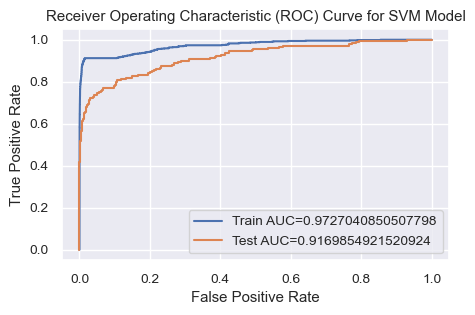

In [37]:
ROC_curve (model_svm, 'Receiver Operating Characteristic (ROC) Curve for SVM Model', lambda x, y: x.predict_proba(y)[:, 1])

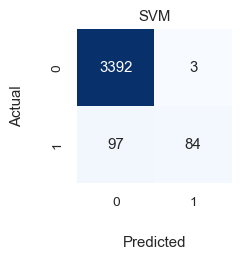

In [38]:
confusion_matrix_map (y_test, y_svm_test_pred, 'SVM')

## Multinomial Naive Bayes Model

In [39]:
# instantiate the model
mnb = MultinomialNB()
# fit the model
mnb.fit(X_train, y_train)
#use model to make predictions on train data
y_mnb_train_pred = mnb.predict(X_train)
#Predict the response for test dataset
y_mnb_test_pred = mnb.predict(X_test)
# print the scores on training and test set
print('Training set score: {:.4f}'.format(mnb.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(mnb.score(X_test, y_test)))

Training set score: 0.9617
Test set score: 0.9620


### Multinomial Naive Bayes Model Evaluation on Train and Test Data

In [40]:
mnb_train_accuracy = accuracy_score(y_train, y_mnb_train_pred)
mnb_train_precision = precision_score(y_train, y_mnb_train_pred, average='weighted')
mnb_train_recall = recall_score(y_train, y_mnb_train_pred, average='weighted')
mnb_train_f1score_test = f1_score(y_train, y_mnb_train_pred, average='weighted')
print(f"accuracy train data: {mnb_train_accuracy}")
print(f"precision train data: {mnb_train_precision}")
print(f"recall train data: {mnb_train_recall}")
print(f"F1 Score_test = {mnb_train_f1score_test}")

accuracy train data: 0.9616890380313199
precision train data: 0.9598016596760814
recall train data: 0.9616890380313199
F1 Score_test = 0.9504003570030589


In [41]:
mnb_test_accuracy = accuracy_score(y_test, y_mnb_test_pred)
mnb_test_precision = precision_score(y_test, y_mnb_test_pred, average='weighted')
mnb_test_recall = recall_score(y_test, y_mnb_test_pred, average='weighted')
mnb_test_f1score_test = f1_score(y_test, y_mnb_test_pred, average='weighted')
print(f"accuracy test data: {mnb_test_accuracy}")
print(f"precision test data: {mnb_test_precision}")
print(f"recall test data: {mnb_test_recall}")
print(f"F1 Score_test = {mnb_test_f1score_test}")

accuracy test data: 0.9619686800894854
precision test data: 0.9626048753397608
recall test data: 0.9619686800894854
F1 Score_test = 0.951160819359648


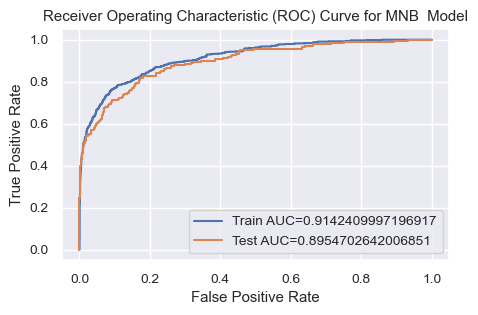

In [42]:
ROC_curve (mnb, 'Receiver Operating Characteristic (ROC) Curve for MNB  Model', lambda x, y: x.predict_proba(y)[:, 1])

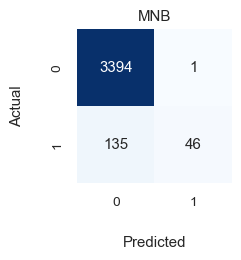

In [43]:
confusion_matrix_map (y_test, y_mnb_test_pred, 'MNB')

## Fully Connected Neural Networks Model

In [44]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = tf.keras.optimizers.Adam()   # learning_rate=learning_rate
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [45]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="accuracy", max_trials=5, overwrite=True,
    directory="my_classification", project_name="final_project", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           )

Trial 5 Complete [00h 00m 40s]
accuracy: 0.999370813369751

Best accuracy So Far: 0.9996504187583923
Total elapsed time: 00h 05m 20s


In [46]:
top1_model = random_search_tuner.get_best_models(num_models=1)
model_1 = top1_model[0]

In [47]:
top1_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top1_params[0].values  # best hyperparameter values

{'n_hidden': 2, 'n_neurons': 230, 'learning_rate': 0.000505466655750672}

In [48]:
start_time_1 = timeit.default_timer()
model_1.fit(X_train, y_train, epochs=10)
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
end_time_1 = timeit.default_timer()
computation_time_1 = end_time_1 - start_time_1
print(f"Efficient method time: {computation_time_1}")

Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9995 - loss: 0.0017
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9988 - loss: 0.0038
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9998 - loss: 5.7565e-04
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9999 - loss: 2.1545e-04
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 1.0000 - loss: 5.9942e-05
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9996 - loss: 0.0021
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9998 - loss: 3.3219e-04
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 1.0000 - loss: 1.4408e-04
Epoch 9/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9997 - loss: 8.9435e-04
Epoch 10/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9999 - loss: 1.9628e-04
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9736 - loss: 0.3332
Efficient method time: 87

In [49]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (32, 3000)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 230)                   │         690,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 230)                   │          53,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 10)                    │           2,310 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,237,012 (8.53 MB)

 Trainable params: 745,670 (2.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,491,342 (5.69 MB)

In [50]:
y_nn_train_pred = np.argmax(model_1.predict(X_train),axis=1)

447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


### Neural Networks Model Evaluation on Train and Test Data

In [51]:
nn_train_accuracy = round(accuracy_score(y_train, y_nn_train_pred), 3)
nn_train_precision = round(precision_score(y_train, y_nn_train_pred, average='weighted'), 3)
nn_train_recall = round(recall_score(y_train, y_nn_train_pred, average='weighted'), 3)
nn_train_f1score_test = f1_score(y_train, y_nn_train_pred, average='weighted')
print(f"accuracy: {nn_train_accuracy}")
print(f"precision: {nn_train_precision}")
print(f"recall: {nn_train_recall}")
print(f"F1 Score_test = {nn_train_f1score_test}")

accuracy: 1.0
precision: 1.0
recall: 1.0
F1 Score_test = 0.9995808272428115


In [52]:
y_nn_test_pred = np.argmax(model_1.predict(X_test),axis=1)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [53]:
nn_test_accuracy = round(accuracy_score(y_test, y_nn_test_pred), 3)
nn_test_precision = round(precision_score(y_test, y_nn_test_pred, average='weighted'), 3)
nn_test_recall = round(recall_score(y_test, y_nn_test_pred, average='weighted'), 3)
nn_test_f1score_test = f1_score(y_test, y_nn_test_pred, average='weighted')
print(f"accuracy: {nn_test_accuracy}")
print(f"precision: {nn_test_precision}")
print(f"recall: {nn_test_recall}")
print(f"F1 Score_test = {nn_test_f1score_test}")

accuracy: 0.973
precision: 0.971
recall: 0.973
F1 Score_test = 0.9715655424548844


447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


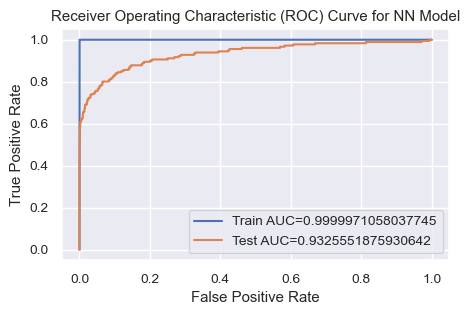

In [54]:
ROC_curve (model_1, 'Receiver Operating Characteristic (ROC) Curve for NN Model', lambda x, y: x.predict(y)[:, 1])

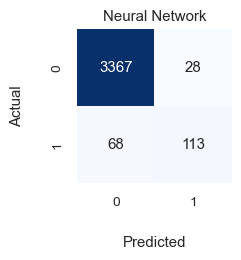

In [55]:
confusion_matrix_map (y_test, y_nn_test_pred, 'Neural Network')

<hr style="border: 2px solid orange;" />

## Results

In [56]:
t1 = pd.Series({'Model': 'Random Forest', 
               'Accuracy': rf_train_accuracy, 
               'Precision': rf_train_precision,
               'Recall': rf_train_recall,
               'F1 score' : rf_train_f1score_test,
               })
t2 = pd.Series({'Model': 'Support Vector Machines', 
               'Accuracy': svm_train_accuracy, 
               'Precision': svm_train_precision,
               'Recall': svm_train_recall,
               'F1 score' : svm_train_f1score_test,
               })
t3 = pd.Series({'Model': 'Multinomial Naive Bayes', 
               'Accuracy': mnb_train_accuracy, 
               'Precision': mnb_train_precision,
               'Recall': mnb_train_recall,
               'F1 score' : mnb_train_f1score_test,
               })
t4 = pd.Series({'Model': 'Neural networks', 
               'Accuracy': nn_train_accuracy, 
               'Precision': nn_train_precision,
               'Recall': nn_train_recall,
               'F1 score' : nn_train_f1score_test,
               })

In [57]:
s1 = pd.Series({'Model': 'Random Forest', 
               'Accuracy': rf_test_accuracy, 
               'Precision': rf_test_precision,
               'Recall': rf_test_recall,
               'F1 score' : rf_test_f1score_test,
               })
s2 = pd.Series({'Model': 'Support Vector Machines', 
               'Accuracy': svm_test_accuracy, 
               'Precision': svm_test_precision,
               'Recall': svm_test_recall,
               'F1 score' : svm_test_f1score_test,
               })
s3 = pd.Series({'Model': 'Multinomial Naive Bayes', 
               'Accuracy': mnb_test_accuracy, 
               'Precision': mnb_test_precision,
               'Recall': mnb_test_recall,
               'F1 score' : mnb_test_f1score_test,
               })
s4 = pd.Series({'Model': 'Neural networks', 
               'Accuracy': nn_test_accuracy, 
               'Precision': nn_test_precision,
               'Recall': nn_test_recall,
               'F1 score' : nn_test_f1score_test,
               })

In [58]:
list_of_rows1=[t1, t2, t3, t4]
list_of_rows2=[s1, s2, s3, s4]
pd.DataFrame(list_of_rows1)

,Model,Accuracy,Precision,Recall,F1 score
0,Random Forest,0.999930,0.999930,0.999930,0.999930
1,Support Vector Machines,0.977629,0.977889,0.977629,0.974457
2,Multinomial Naive Bayes,0.961689,0.959802,0.961689,0.950400
3,Neural networks,1.000000,1.000000,1.000000,0.999581


In [59]:
pd.DataFrame(list_of_rows2)

,Model,Accuracy,Precision,Recall,F1 score
0,Random Forest,0.977349,0.977641,0.977349,0.974318
1,Support Vector Machines,0.972036,0.971860,0.972036,0.967323
2,Multinomial Naive Bayes,0.961969,0.962605,0.961969,0.951161
3,Neural networks,0.973000,0.971000,0.973000,0.971566


<hr style="border: 2px solid orange;" />

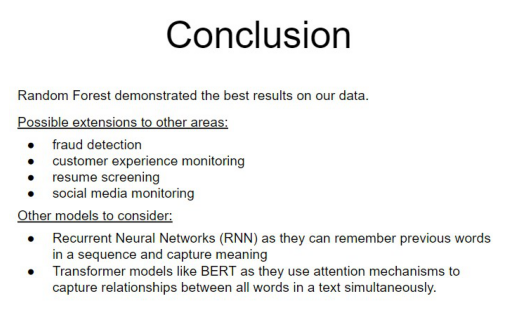

In [63]:
_=plt.figure(figsize=(7, 5), dpi=90)
plt.axis('off')
conclusion = plt.imread('Conclusion.jpg')
plt.grid(False)
_=plt.imshow(conclusion)